In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from copy import deepcopy

# Downloading dataset


In [2]:
dataset = load_dataset('Falah/Alzheimer_MRI', split='train')
test = load_dataset('Falah/Alzheimer_MRI', split='test')

README.md:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

(…)-00000-of-00001-c08a401c53fe5312.parquet:   0%|          | 0.00/22.6M [00:00<?, ?B/s]

(…)-00000-of-00001-44110b9df98c5585.parquet:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

# Data Preprocessing


In [3]:
df = pd.DataFrame.from_dict(dataset)

In [4]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 5120
})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5120 entries, 0 to 5119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5120 non-null   object
 1   label   5120 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 80.1+ KB


In [6]:
df.isnull().sum()

image    0
label    0
dtype: int64

In [7]:
df.describe()

,label
count,5120.000000
mean,2.055469
std,0.959244
min,0.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,3.000000


In [8]:
images = []
labels = []

for i in dataset:
    images += [np.array(i["image"])]
    labels += [i["label"]]
    
images = np.array(images)
labels = np.array(labels)

# Preprocessing pipeline and splitting the batch


In [9]:
class PreProcess(Dataset):
    def __init__(self, images, labels, transform):
        super(PreProcess, self).__init__()
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, x):
        img, label = self.images[x], self.labels[x]
        img = self.transform(img.reshape(img.shape[0], img.shape[1], 1))
        
        
        return img, label

In [10]:
transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5],
                                                   std=[0.5])])

In [11]:
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, random_state=42, test_size=0.2)

# Training hyper-parameters

In [12]:
EPOCHS = 100
LR = 0.01
GAMMA = 0.5
STEP = 20
BATCH = 64
OUT_SIZE = 4

# Creating the dataset and dataloader iterators

In [13]:
train_ds = PreProcess(train_images, train_labels, transform)
val_ds = PreProcess(val_images, val_labels, transform)

In [14]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

# Classification model with skip connections

In [15]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding, change=True):
        super(Block, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels, in_channels, kernel, padding=padding),
                                 nn.BatchNorm2d(in_channels),
                                 nn.ReLU(),
                                 nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
                                 nn.BatchNorm2d(out_channels),
                                 nn.ReLU())
        
        self.change = change
        
        if change:
            self.pool = nn.AvgPool2d(2)
        
        
    def forward(self, x):
        y = self.conv(x)
        if self.change:
            y = self.pool(y)
            return y
        
        y = torch.add(y, x)
        return y

class AlzheimerClassifier(nn.Module):
    def __init__(self, in_channels, out_size):
        super(AlzheimerClassifier, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3),
                                  nn.BatchNorm2d(3),
                                  nn.ReLU())
        
        self.blocks = nn.Sequential(Block(3, 3, 3, 1, False),
                                    Block(3, 16, 3, 0, True),
                                    Block(16, 16, 3, 1, False),
                                   Block(16, 32, 3, 0, True),
                                   Block(32, 32, 3, 1, False),
                                   Block(32, 64, 3, 0, True),
                                   nn.AvgPool2d(2))
        
        self.fc = nn.Linear(2304, out_size)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.blocks(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return nn.functional.softmax(x, dim=1)

# Training device


In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Model training parameters

In [17]:
model = AlzheimerClassifier(1, OUT_SIZE)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR,momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

# Training loop

In [18]:
best_mode = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()
    
    diff = 0
    acc = 0
    total = 0
    
    for data, target in train_dl:
        optimizer.zero_grad()
        
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        
        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()
        
    train_loss += [diff/total]
    train_acc += [acc/total]
    
    model.eval()
    
    diff = 0
    acc = 0
    total = 0
    with torch.no_grad():
        for data, target in val_dl:

            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)
    val_loss += [diff/total]
    val_acc += [acc/total]
    
    if val_acc[-1] >= best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)
        
    print("Epoch {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1], train_acc[-1],
                                                                   val_loss[-1], val_acc[-1]))
    scheduler.step()

Epoch 1 train loss 0.018640785303432494 acc 0.528564453125 val loss 0.0201343015069142 acc 0.451171875
Epoch 2 train loss 0.018003444536589086 acc 0.580322265625 val loss 0.01873912534210831 acc 0.5419921875
Epoch 3 train loss 0.017822104709921405 acc 0.596923828125 val loss 0.02190422173589468 acc 0.341796875
Epoch 4 train loss 0.01754651292867493 acc 0.6142578125 val loss 0.017369742854498327 acc 0.634765625
Epoch 5 train loss 0.017422628036001697 acc 0.624267578125 val loss 0.021597411949187517 acc 0.341796875
Epoch 6 train loss 0.01733685319777578 acc 0.627197265625 val loss 0.017284145927987993 acc 0.6318359375
Epoch 7 train loss 0.017045063199475408 acc 0.6513671875 val loss 0.018385358969680965 acc 0.546875
Epoch 8 train loss 0.016900776157854125 acc 0.659423828125 val loss 0.01674502744572237 acc 0.673828125
Epoch 9 train loss 0.016556882648728788 acc 0.68505859375 val loss 0.017799981054849923 acc 0.5869140625
Epoch 10 train loss 0.016461710853036493 acc 0.6884765625 val loss 

# Training performance log


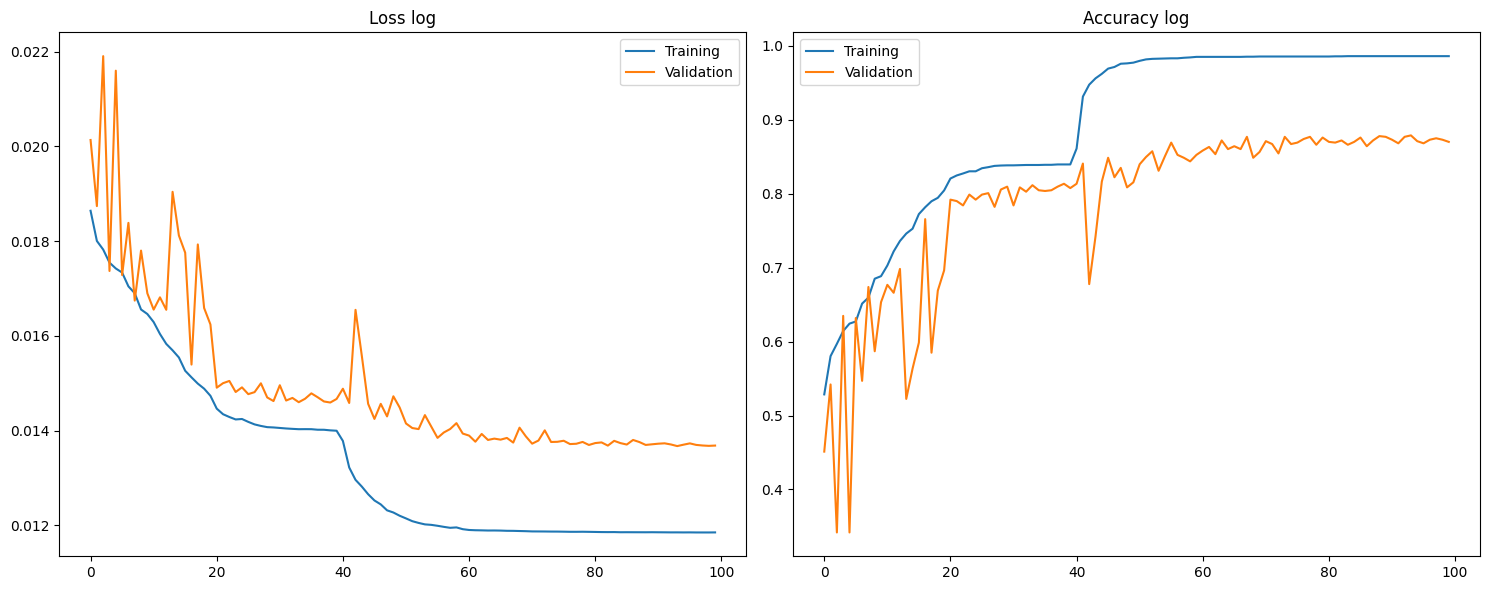

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

index = 0

axes[index].plot(train_loss, label="Training")
axes[index].plot(val_loss, label="Validation")
axes[index].legend()
axes[index].set_title("Loss log")

index += 1

axes[index].plot(train_acc, label="Training")
axes[index].plot(val_acc, label="Validation")
axes[index].legend()
axes[index].set_title("Accuracy log")

plt.tight_layout()
plt.show()

In [20]:
def predict(img):
    img = transform(img).view(1, 1, 128, 128)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        out = model(img)
        
    index = out.argmax(1).item()
    return index, out.cpu().detach().numpy()[0][index]

# Mapping Pipeline

In [21]:
index_label = {0: "Mild Demented",
1: "Moderate Demented",
2: "Non Demented",
3: "Very Mild Demented"}

# Predict TestValues

In [22]:
pred = []
proba = []
truth = []

for i in test:
    index, conf = predict(np.array(i["image"]))
    pred += [index]
    proba += [conf]
    truth += [i["label"]]

# Test values evaluation


              precision    recall  f1-score   support

           0       0.77      0.65      0.71       205
           1       0.00      0.00      0.00         0
           2       0.92      0.89      0.91       659
           3       0.82      0.91      0.86       416

    accuracy                           0.86      1280
   macro avg       0.63      0.61      0.62      1280
weighted avg       0.87      0.86      0.86      1280



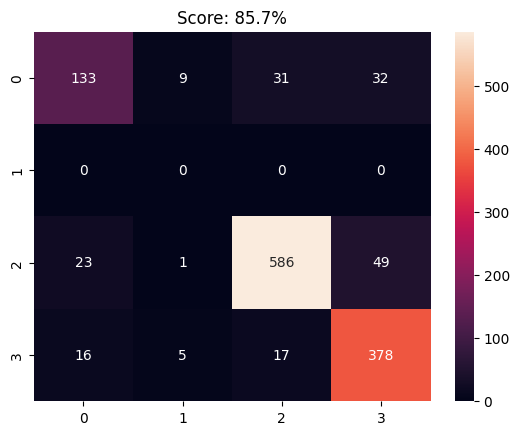

In [23]:
score = accuracy_score(pred, truth)
cm = confusion_matrix(pred, truth)
report = classification_report(pred, truth)
print(report)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Score: {}%".format(round(score*100, 2)))
plt.show()

# Visual inspection of results with confidence scores

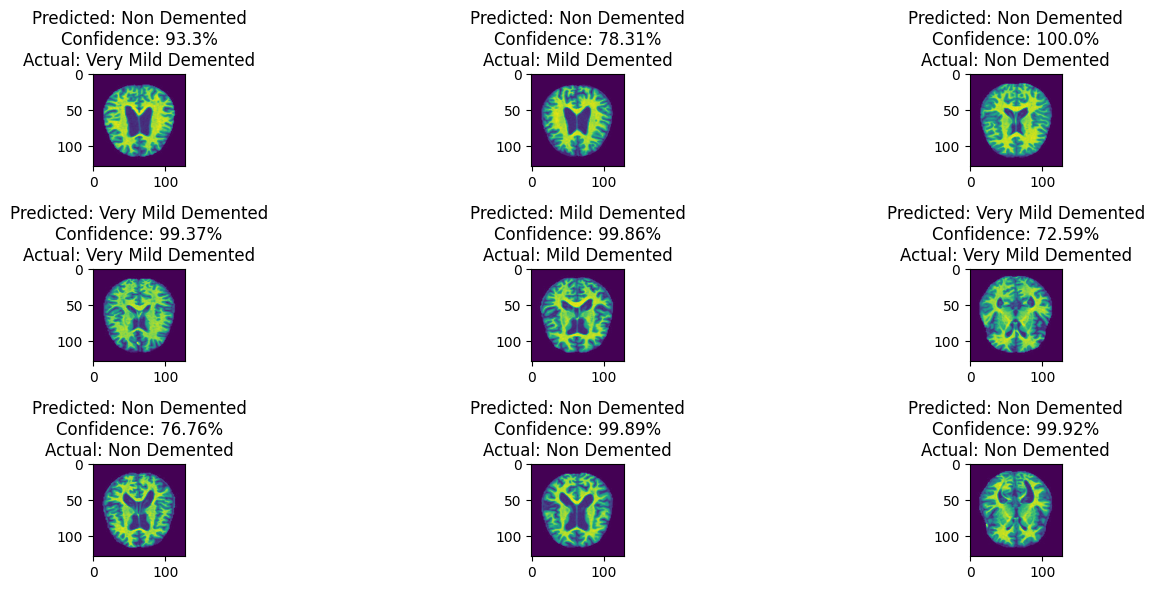

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 6))
index = 0

for i in range(3):
    for j in range(3):
        axes[i][j].imshow(np.array(test[index]["image"]))
        axes[i][j].set_title("Predicted: {}\nConfidence: {}%\nActual: {}".format(index_label[pred[index]],
                                                                             round(proba[index]*100, 2),
                                                                             index_label[truth[index]]))
        index += 1
plt.tight_layout()
plt.show()

# TRAINING LOOP CNN+LSTM

In [25]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, use_pool=True):
        super(ConvBlock, self).__init__()
        self.conv_layer = nn.Sequential(nn.Conv2d(in_channels, in_channels, kernel_size, padding=padding),
                                        nn.BatchNorm2d(in_channels),
                                        nn.ReLU(),
                                        nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                                        nn.BatchNorm2d(out_channels),
                                        nn.ReLU())
        
        self.use_pool = use_pool
        
        if use_pool:
            self.pool_layer = nn.AvgPool2d(2)
        
    def forward(self, input_tensor):
        output_tensor = self.conv_layer(input_tensor)
        if self.use_pool:
            output_tensor = self.pool_layer(output_tensor)
            return output_tensor
        
        output_tensor = torch.add(output_tensor, input_tensor)
        return output_tensor

class AlzheimerLSTMClassifier(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(AlzheimerLSTMClassifier, self).__init__()
        self.initial_conv = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3),
                                          nn.BatchNorm2d(3),
                                          nn.ReLU())
        
        self.conv_blocks = nn.Sequential(ConvBlock(3, 3, 3, 1, False),
                                         ConvBlock(3, 16, 3, 0, True),
                                         ConvBlock(16, 16, 3, 1, False),
                                         ConvBlock(16, 32, 3, 0, True),
                                         ConvBlock(32, 32, 3, 1, False),
                                         ConvBlock(32, 64, 3, 0, True),
                                         nn.AvgPool2d(2))
        
        # Set LSTM parameters
        self.lstm_input_dim = 64  # Adjust according to the flattened output shape of your CNN
        self.lstm_hidden_dim = 128
        self.lstm_layers = 1
        
        self.lstm_layer = nn.LSTM(input_size=self.lstm_input_dim, hidden_size=self.lstm_hidden_dim, 
                                  num_layers=self.lstm_layers, batch_first=True)
        
        self.fc_layer = nn.Linear(self.lstm_hidden_dim, num_classes)
        
    def forward(self, x):
        x = self.initial_conv(x)
        x = self.conv_blocks(x)
        
        # Flattening to sequence
        batch_size = x.size(0)
        x = torch.flatten(x, 2)  # shape: (batch_size, channels, sequence_length)
        x = x.permute(0, 2, 1)   # shape: (batch_size, sequence_length, channels)
        
        # Passing through LSTM
        lstm_out, (hidden_state, cell_state) = self.lstm_layer(x)
        lstm_out = lstm_out[:, -1, :]  # Take the output from the last time step
        
        x = self.fc_layer(lstm_out)
        
        return nn.functional.softmax(x, dim=1)


In [26]:
# Define the model using AlzheimerLSTMClassifier instead of AlzheimerClassifier
model = AlzheimerLSTMClassifier(1, OUT_SIZE)

# Move the model to the available device (CUDA or CPU)
model = model.to(device)

# Loss function: Cross Entropy is still suitable for classification tasks
criterion = nn.CrossEntropyLoss()

# Optimizer: Using Stochastic Gradient Descent (SGD)
optimizer = torch.optim.SGD(model.parameters(), lr=LR,momentum=0.9)

# Learning Rate Scheduler: StepLR with specified step size and gamma
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)


In [27]:
import torch
from copy import deepcopy

# Assuming 'model' is an instance of AlzheimerLSTMClassifier
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    
    epoch_train_loss = 0
    epoch_train_acc = 0
    total_train_samples = 0
    
    for batch_data, batch_target in train_dl:
        optimizer.zero_grad()
        
        if torch.cuda.is_available():
            batch_data, batch_target = batch_data.cuda(), batch_target.cuda()
        
        # Forward pass
        output = model(batch_data)
        loss = criterion(output, batch_target)
        
        # Accumulate loss and accuracy
        epoch_train_loss += loss.item()
        epoch_train_acc += (output.argmax(1) == batch_target).sum().item()
        total_train_samples += output.size(0)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
    train_loss.append(epoch_train_loss / total_train_samples)
    train_acc.append(epoch_train_acc / total_train_samples)
    
    # Validation phase
    model.eval()
    
    epoch_val_loss = 0
    epoch_val_acc = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for batch_data, batch_target in val_dl:

            if torch.cuda.is_available():
                batch_data, batch_target = batch_data.cuda(), batch_target.cuda()

            # Forward pass
            output = model(batch_data)
            loss = criterion(output, batch_target)
            
            # Accumulate validation loss and accuracy
            epoch_val_loss += loss.item()
            epoch_val_acc += (output.argmax(1) == batch_target).sum().item()
            total_val_samples += output.size(0)
    
    val_loss.append(epoch_val_loss / total_val_samples)
    val_acc.append(epoch_val_acc / total_val_samples)
    
    # Check if current model has the best accuracy
    if val_acc[-1] >= best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)
        
    # Print epoch statistics
    print(f"Epoch {epoch} | Train Loss: {train_loss[-1]:.4f} | Train Acc: {train_acc[-1]:.4f} | "
          f"Val Loss: {val_loss[-1]:.4f} | Val Acc: {val_acc[-1]:.4f}")
    
    # Step the learning rate scheduler
    scheduler.step()


Epoch 1 | Train Loss: 0.0205 | Train Acc: 0.4963 | Val Loss: 0.0190 | Val Acc: 0.5205
Epoch 2 | Train Loss: 0.0192 | Train Acc: 0.4963 | Val Loss: 0.0187 | Val Acc: 0.5205
Epoch 3 | Train Loss: 0.0189 | Train Acc: 0.5073 | Val Loss: 0.0184 | Val Acc: 0.5547
Epoch 4 | Train Loss: 0.0186 | Train Acc: 0.5256 | Val Loss: 0.0188 | Val Acc: 0.5332
Epoch 5 | Train Loss: 0.0185 | Train Acc: 0.5281 | Val Loss: 0.0185 | Val Acc: 0.5352
Epoch 6 | Train Loss: 0.0182 | Train Acc: 0.5637 | Val Loss: 0.0185 | Val Acc: 0.5566
Epoch 7 | Train Loss: 0.0181 | Train Acc: 0.5654 | Val Loss: 0.0183 | Val Acc: 0.5449
Epoch 8 | Train Loss: 0.0179 | Train Acc: 0.5854 | Val Loss: 0.0179 | Val Acc: 0.5869
Epoch 9 | Train Loss: 0.0178 | Train Acc: 0.5903 | Val Loss: 0.0187 | Val Acc: 0.5273
Epoch 10 | Train Loss: 0.0178 | Train Acc: 0.5957 | Val Loss: 0.0183 | Val Acc: 0.5703
Epoch 11 | Train Loss: 0.0176 | Train Acc: 0.6116 | Val Loss: 0.0179 | Val Acc: 0.5996
Epoch 12 | Train Loss: 0.0177 | Train Acc: 0.6033 | 

# Training performance log

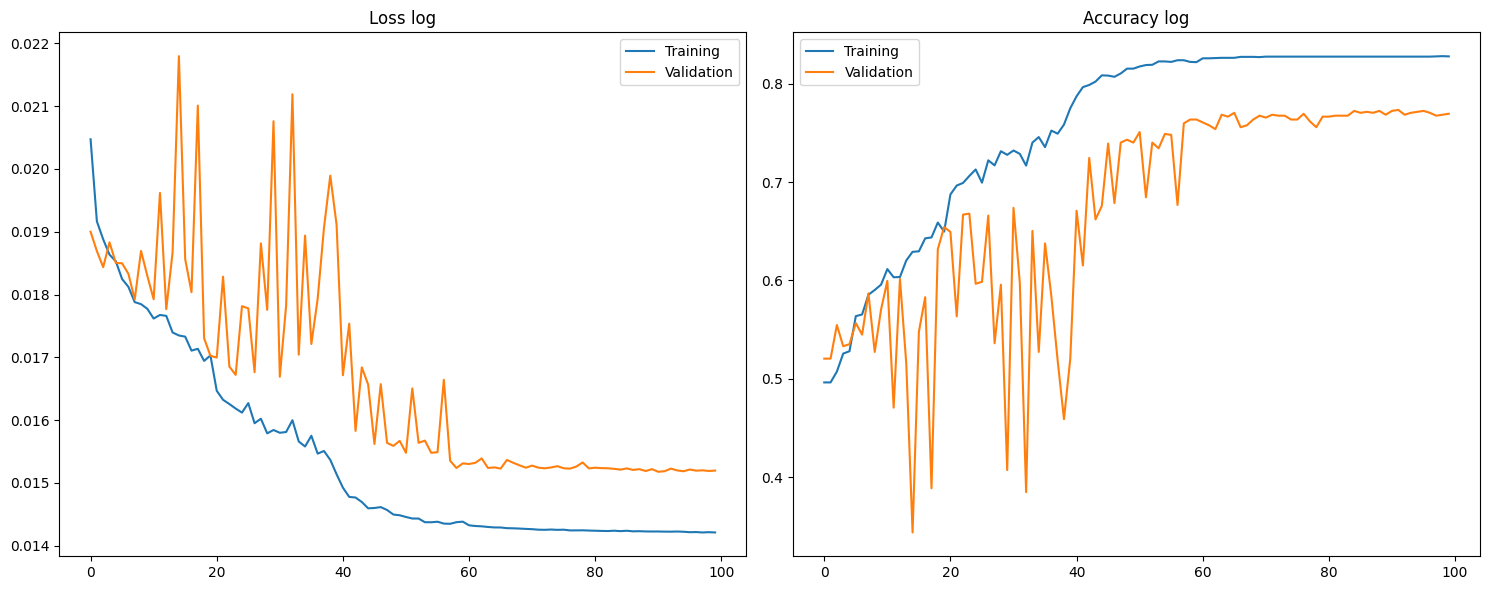

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

index = 0

axes[index].plot(train_loss, label="Training")
axes[index].plot(val_loss, label="Validation")
axes[index].legend()
axes[index].set_title("Loss log")

index += 1

axes[index].plot(train_acc, label="Training")
axes[index].plot(val_acc, label="Validation")
axes[index].legend()
axes[index].set_title("Accuracy log")

plt.tight_layout()
plt.show()

# Predict TestValues

In [29]:
def predict(img):
    # Transform the image and reshape it for the model
    img = transform(img).view(1, 1, 128, 128)  # 1 batch, 1 channel, 128x128 size
    best_model.eval()  # Ensure the model is in evaluation mode
    
    with torch.no_grad():
        # Move the image to GPU if available
        if torch.cuda.is_available():
            img = img.cuda()

        # Forward pass through the best_model (using LSTM + CNN)
        out = best_model(img)
    
    # Get the index of the highest score (predicted class) and its confidence score
    predicted_class = out.argmax(1).item()
    confidence_score = out.cpu().detach().numpy()[0][predicted_class]
    
    return predicted_class, confidence_score

In [30]:
pred = []
proba = []
truth = []

for i in test:
    index, conf = predict(np.array(i["image"]))
    pred += [index]
    proba += [conf]
    truth += [i["label"]]

# Test values evaluation

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.91      0.82      0.86       709
           3       0.84      0.67      0.75       571

    accuracy                           0.75      1280
   macro avg       0.44      0.37      0.40      1280
weighted avg       0.88      0.75      0.81      1280



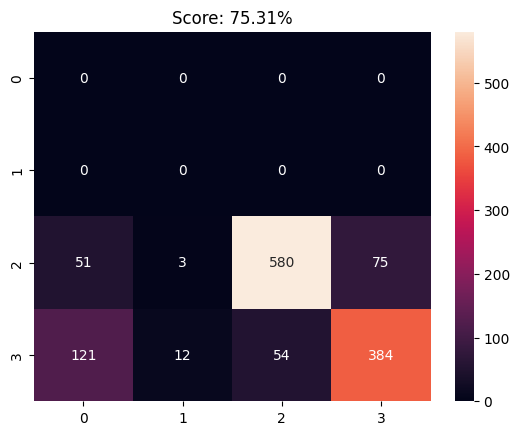

In [31]:
score = accuracy_score(pred, truth)
cm = confusion_matrix(pred, truth)
report = classification_report(pred, truth)
print(report)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Score: {}%".format(round(score*100, 2)))
plt.show()

# Visual inspection of results with confidence scores*

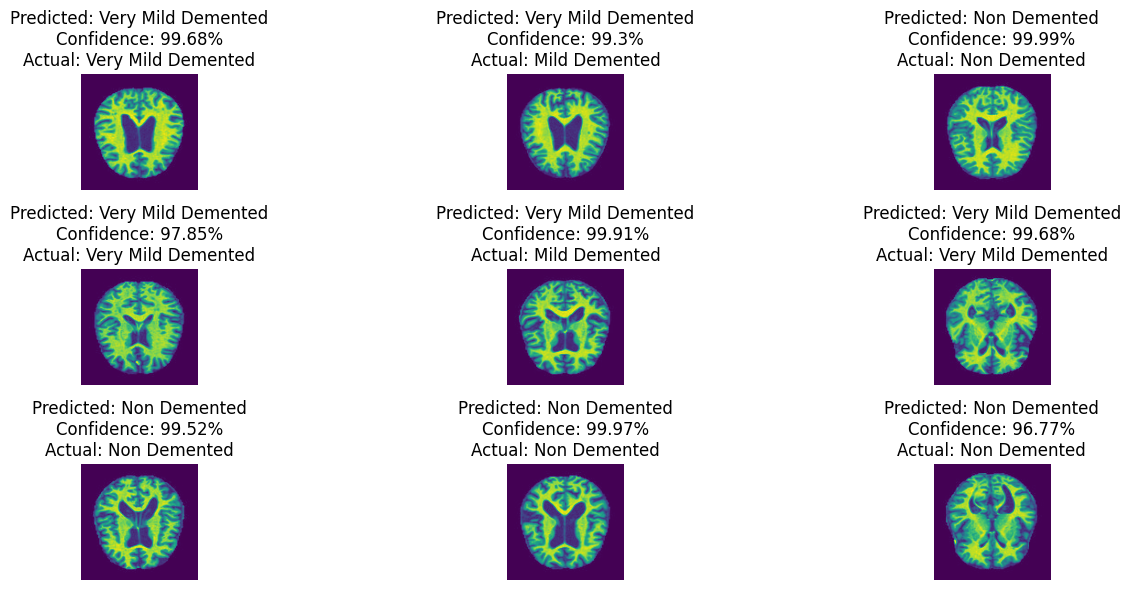

In [32]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 6))
index = 0

# Loop through the grid to plot images with predictions, confidence, and true labels
for i in range(3):
    for j in range(3):
        # Display the image in color
        axes[i][j].imshow(np.array(test[index]["image"]))  # No cmap, so it shows color if available
        
        # Set title with predicted label, confidence score, and actual label
        axes[i][j].set_title(
            "Predicted: {}\nConfidence: {}%\nActual: {}".format(
                index_label[pred[index]],
                round(proba[index] * 100, 2),
                index_label[truth[index]]
            )
        )
        
        # Hide axis
        axes[i][j].axis('off')
        
        index += 1

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


# TRAINING LOOP CNN+BiLSTM

In [33]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, use_pool=True):
        super(ConvBlock, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size, padding=padding),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.use_pool = use_pool
        
        if use_pool:
            self.pool_layer = nn.AvgPool2d(2)
        
    def forward(self, input_tensor):
        output_tensor = self.conv_layer(input_tensor)
        if self.use_pool:
            output_tensor = self.pool_layer(output_tensor)
        else:
            output_tensor = torch.add(output_tensor, input_tensor)  # Residual connection for non-pooling layers
        return output_tensor

class AlzheimerBiLSTMClassifier(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(AlzheimerBiLSTMClassifier, self).__init__()
        # Initial Convolution block
        self.initial_conv = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=3, kernel_size=3),
            nn.BatchNorm2d(3),
            nn.ReLU()
        )
        
        # Stack of convolutional blocks
        self.conv_blocks = nn.Sequential(
            ConvBlock(3, 3, 3, 1, False),  # Residual block
            ConvBlock(3, 16, 3, 0, True),  # Pooling block
            ConvBlock(16, 16, 3, 1, False),  # Residual block
            ConvBlock(16, 32, 3, 0, True),  # Pooling block
            ConvBlock(32, 32, 3, 1, False),  # Residual block
            ConvBlock(32, 64, 3, 0, True),  # Pooling block
            nn.AvgPool2d(2)
        )
        
        # BiLSTM parameters
        self.lstm_input_dim = 64  # Adjust to flattened output from CNN blocks
        self.lstm_hidden_dim = 128
        self.lstm_layers = 1
        self.bidirectional = True
        self.num_directions = 2 if self.bidirectional else 1
        
        # BiLSTM layer
        self.lstm_layer = nn.LSTM(
            input_size=self.lstm_input_dim,
            hidden_size=self.lstm_hidden_dim,
            num_layers=self.lstm_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )
        
        # Fully connected layer for classification
        self.fc_layer = nn.Linear(self.lstm_hidden_dim * self.num_directions, num_classes)
    
    def forward(self, x):
        # CNN Feature extraction
        x = self.initial_conv(x)
        x = self.conv_blocks(x)
        
        # Flatten to a sequence for LSTM input
        batch_size = x.size(0)
        x = torch.flatten(x, 2)  # Flatten height and width to a single dimension
        x = x.permute(0, 2, 1)   # Reshape to (batch_size, sequence_length, features)
        
        # Pass through BiLSTM
        lstm_out, (hidden_state, cell_state) = self.lstm_layer(x)
        
        # Take the output from the last time step
        lstm_out = lstm_out[:, -1, :]  # Take output of the final time step
        
        # Pass through fully connected layer
        x = self.fc_layer(lstm_out)
        
        return nn.functional.softmax(x, dim=1)



In [34]:
# Define the model using AlzheimerBiLSTMClassifier instead of AlzheimerLSTMClassifier
model = AlzheimerBiLSTMClassifier(1, OUT_SIZE)

# Move the model to the available device (CUDA or CPU)
model = model.to(device)

# Loss function: Cross Entropy is still suitable for classification tasks
criterion = nn.CrossEntropyLoss()

# Optimizer: Using Stochastic Gradient Descent (SGD)
optimizer = torch.optim.SGD(model.parameters(), lr=LR,momentum=0.9)

# Learning Rate Scheduler: StepLR with specified step size and gamma
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)


In [35]:
import torch
from copy import deepcopy

# Assuming 'model' is an instance of AlzheimerBiLSTMClassifier
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(1, EPOCHS + 1):
    model.train()  # Set the model to training mode
    
    epoch_train_loss = 0
    epoch_train_acc = 0
    total_train_samples = 0
    
    for batch_data, batch_target in train_dl:
        optimizer.zero_grad()  # Zero the gradients
        
        if torch.cuda.is_available():
            batch_data, batch_target = batch_data.cuda(), batch_target.cuda()
        
        # Forward pass
        output = model(batch_data)
        loss = criterion(output, batch_target)
        
        # Accumulate loss and accuracy
        epoch_train_loss += loss.item()
        epoch_train_acc += (output.argmax(1) == batch_target).sum().item()
        total_train_samples += output.size(0)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
    # Average training loss and accuracy
    train_loss.append(epoch_train_loss / total_train_samples)
    train_acc.append(epoch_train_acc / total_train_samples)
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    
    epoch_val_loss = 0
    epoch_val_acc = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for batch_data, batch_target in val_dl:
            if torch.cuda.is_available():
                batch_data, batch_target = batch_data.cuda(), batch_target.cuda()

            # Forward pass
            output = model(batch_data)
            loss = criterion(output, batch_target)
            
            # Accumulate validation loss and accuracy
            epoch_val_loss += loss.item()
            epoch_val_acc += (output.argmax(1) == batch_target).sum().item()
            total_val_samples += output.size(0)
    
    # Average validation loss and accuracy
    val_loss.append(epoch_val_loss / total_val_samples)
    val_acc.append(epoch_val_acc / total_val_samples)
    
    # Check if current model has the best accuracy
    if val_acc[-1] >= best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)  # Keep a copy of the best model
        
    # Print epoch statistics
    print(f"Epoch {epoch} | Train Loss: {train_loss[-1]:.4f} | Train Acc: {train_acc[-1]:.4f} | "
          f"Val Loss: {val_loss[-1]:.4f} | Val Acc: {val_acc[-1]:.4f}")
    
    # Step the learning rate scheduler
    scheduler.step()


Epoch 1 | Train Loss: 0.0202 | Train Acc: 0.4673 | Val Loss: 0.0189 | Val Acc: 0.5205
Epoch 2 | Train Loss: 0.0191 | Train Acc: 0.4963 | Val Loss: 0.0187 | Val Acc: 0.5205
Epoch 3 | Train Loss: 0.0189 | Train Acc: 0.5107 | Val Loss: 0.0185 | Val Acc: 0.5508
Epoch 4 | Train Loss: 0.0186 | Train Acc: 0.5464 | Val Loss: 0.0185 | Val Acc: 0.5322
Epoch 5 | Train Loss: 0.0183 | Train Acc: 0.5623 | Val Loss: 0.0190 | Val Acc: 0.5205
Epoch 6 | Train Loss: 0.0181 | Train Acc: 0.5750 | Val Loss: 0.0196 | Val Acc: 0.4727
Epoch 7 | Train Loss: 0.0179 | Train Acc: 0.5847 | Val Loss: 0.0183 | Val Acc: 0.5625
Epoch 8 | Train Loss: 0.0179 | Train Acc: 0.5935 | Val Loss: 0.0182 | Val Acc: 0.5498
Epoch 9 | Train Loss: 0.0177 | Train Acc: 0.6021 | Val Loss: 0.0184 | Val Acc: 0.5518
Epoch 10 | Train Loss: 0.0177 | Train Acc: 0.6038 | Val Loss: 0.0177 | Val Acc: 0.5986
Epoch 11 | Train Loss: 0.0174 | Train Acc: 0.6255 | Val Loss: 0.0179 | Val Acc: 0.5938
Epoch 12 | Train Loss: 0.0174 | Train Acc: 0.6326 | 

# Training performance log


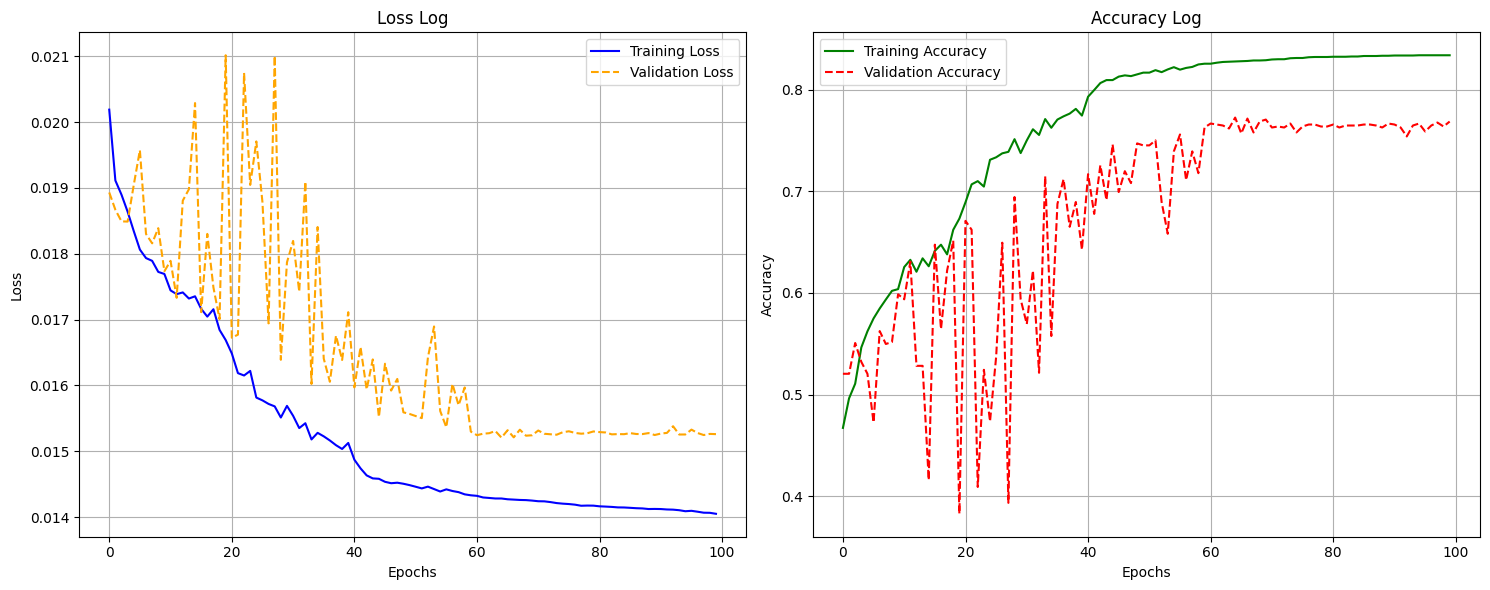

In [36]:
import matplotlib.pyplot as plt

# Create subplots for loss and accuracy
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

# Plotting training and validation loss
axes[0].plot(train_loss, label="Training Loss", color='blue', linestyle='-')
axes[0].plot(val_loss, label="Validation Loss", color='orange', linestyle='--')
axes[0].legend()
axes[0].set_title("Loss Log")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].grid()

# Plotting training and validation accuracy
axes[1].plot(train_acc, label="Training Accuracy", color='green', linestyle='-')
axes[1].plot(val_acc, label="Validation Accuracy", color='red', linestyle='--')
axes[1].legend()
axes[1].set_title("Accuracy Log")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].grid()

plt.tight_layout()
plt.show()


# Predict TestValues

In [37]:
def predict(img):
    # Transform the image and reshape it for the model
    img = transform(img).view(1, 1, 128, 128)  # Assuming input is 128x128 and single channel
    img = img.repeat(1, 3, 1, 1)  # Repeat single channel to match 3-channel RGB

    # Ensure model is in evaluation mode
    best_model.eval()
    
    with torch.no_grad():
        # Move image to GPU if available
        if torch.cuda.is_available():
            img = img.cuda()
            best_model.cuda()

        # Forward pass through the best_model
        out = best_model(img)

        # Optionally, apply softmax if model output is logits
        # out = torch.nn.functional.softmax(out, dim=1)
    
    # Get the index of the highest score (predicted class) and its confidence score
    predicted_class = out.argmax(1).item()
    confidence_score = torch.nn.functional.softmax(out, dim=1)[0][predicted_class].item()

    return predicted_class, confidence_score


In [38]:
import torch
from PIL import Image
import torchvision.transforms as transforms

# Define the transform to convert images to grayscale and resize
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert NumPy array to PIL Image if necessary
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((128, 128)),  # Resize to the expected input size
    transforms.ToTensor()  # Convert to tensor
])

def predict(img):
    # Transform the image and reshape it for the model
    img = transform(img).view(1, 1, 128, 128)  # 1 batch, 1 channel, 128x128 size
    
    best_model.eval()  # Ensure the model is in evaluation mode
    
    with torch.no_grad():
        # Move the image and model to GPU if available
        if torch.cuda.is_available():
            img = img.cuda()
            best_model.cuda()

        # Forward pass through the best_model
        out = best_model(img)

        # Apply softmax to get confidence scores as probabilities
        out = torch.nn.functional.softmax(out, dim=1)
    
    # Get the index of the highest score (predicted class) and its confidence score
    predicted_class = out.argmax(1).item()
    confidence_score = out[0][predicted_class].item()

    return predicted_class, confidence_score


# Test values evaluation

Classification Report:
              precision    recall  f1-score   support

      Class0       0.00      0.00      0.00       136
      Class1       0.00      0.00      0.00         5
      Class2       0.80      0.95      0.87       533
      Class3       0.73      0.81      0.77       350

    accuracy                           0.77      1024
   macro avg       0.38      0.44      0.41      1024
weighted avg       0.67      0.77      0.71      1024



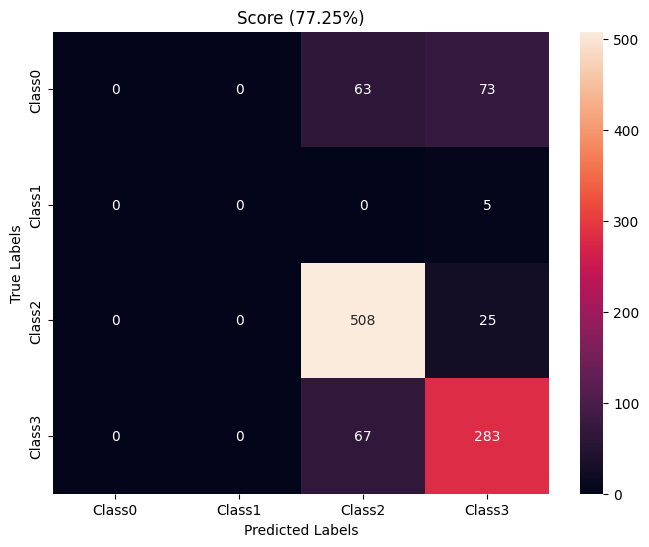

In [45]:
import torch
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the model, generate confusion matrix, classification report, and accuracy score
def evaluate_model(model, val_dl, class_names):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_data, batch_labels in val_dl:
            # Move data to GPU if available
            if torch.cuda.is_available():
                batch_data, batch_labels = batch_data.cuda(), batch_labels.cuda()

            # Forward pass
            outputs = model(batch_data)
            _, preds = torch.max(outputs, 1)  # Get predicted class labels
            
            # Store predictions and true labels
            all_preds.extend(preds.cpu().numpy())  # Move to CPU and convert to NumPy
            all_labels.extend(batch_labels.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)

    # Calculate accuracy score
    accuracy = accuracy_score(all_labels, all_preds)

    return cm, report, accuracy

# Plot the confusion matrix using seaborn's heatmap
def plot_confusion_matrix(cm, class_names, accuracy):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title("Score ({:.2f}%)".format(accuracy * 100))
    plt.show()

# Example usage
class_names = ['Class0', 'Class1', 'Class2', 'Class3']  # Replace with actual class names
cm, report, accuracy = evaluate_model(best_model, val_dl, class_names)

# Print the classification report
print("Classification Report:")
print(report)

# Plot the confusion matrix with accuracy
plot_confusion_matrix(cm, class_names, accuracy)


# Visual inspection of results with confidence scores

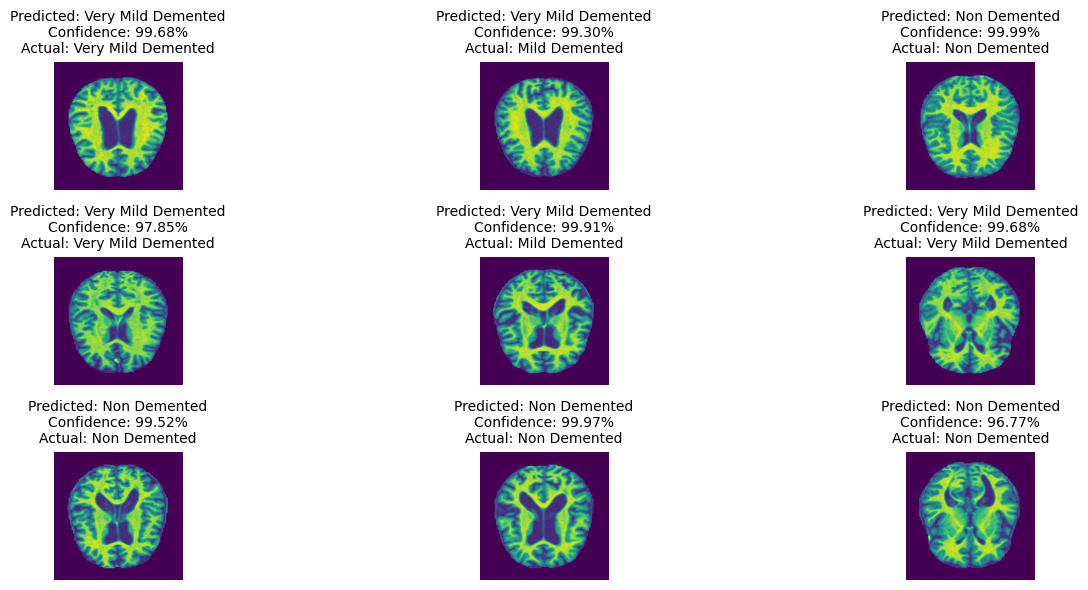

In [40]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Create a 3x3 grid of subplots (for 9 images)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 6))
index = 0  # To keep track of the images

# Loop through the grid to plot images with predictions, confidence, and true labels
for i in range(3):
    for j in range(3):
        # Display the image in color
        axes[i][j].imshow(np.array(test[index]["image"]))  # Assumes 'image' is a key in test
        
        # Set title with predicted label, confidence score, and actual label
        axes[i][j].set_title(
            "Predicted: {}\nConfidence: {:.2f}%\nActual: {}".format(
                index_label[pred[index]],  # Predicted label
                proba[index] * 100,        # Confidence score in percentage
                index_label[truth[index]]  # Actual label
            ),
            fontsize=10
        )
        
        # Hide the axes for a cleaner look
        axes[i][j].axis('off')
        
        # Move to the next image in the dataset
        index += 1

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()
